In [1]:
import os
import os.path
#abspath = os.path.abspath(__file__)
#dname = os.path.dirname(abspath)
#os.chdir(dname)
import rrsBdtDevDependencies
import dataFunctions as dataFun
from datetime import datetime as dt

In [39]:
### CONFIGURE ###
barrels = 750000
costPerDay = 30000
days = 1
trainDataDate = '2018-01-01'

In [2]:
print('Running...')

def show_more(df, lines):
    with pd.option_context("display.max_rows", lines):
        display(df)

Running...


In [3]:
import quandl
wtiData = quandl.get("FRED/DCOILWTICO")

In [4]:
wtiData.reset_index(level=0, inplace=True)
wtiData = wtiData.rename(columns={"Value": "Prices"})
wtiData.head()

,Date,Prices
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87


In [5]:
import yfinance as yf

yfStartDate = wtiData['Date'].iloc[-1].strftime('%Y-%m-%d')
stocks = "CL=F"
period = "1d"
Stocks, yfInfo = dataFun.yFinData(yfStartDate)

wtiData = wtiData.append(Stocks, ignore_index =True)
wtiData = wtiData.sort_values(by = ["Date"])

[*********************100%***********************]  1 of 1 completed


In [6]:
import numpy as np
oilDF = dataFun.oilProduction()

df = dataFun.combineFrames(wtiData,oilDF)
df = df[np.isfinite(df['Prices'])]
df = df.reset_index().drop(["index"], axis = 1)
df

,Date,Prices,Production of Crude Oil
0,1986-01-03,26.000000,8942.0
1,1986-01-06,26.530000,8942.0
2,1986-01-07,25.850000,8942.0
3,1986-01-08,25.870000,8942.0
4,1986-01-09,26.030000,8942.0
...,...,...,...
8572,2020-01-06,62.820000,12900.0
8573,2020-01-07,64.779999,12900.0
8574,2020-01-08,59.950001,12900.0
8575,2020-01-09,59.529999,12900.0


In [7]:
natGasData = quandl.get("EIA/NG_RNGWHHD_D")
natGasData.reset_index(level=0, inplace=True)
natGasData = natGasData.rename(columns={"Value": "NatGasPrices"})

yfStartDate = natGasData['Date'].iloc[-1].strftime('%Y-%m-%d')
stocks = "NG=F"
period = "1d"
NGStocks, yfInfo = dataFun.yFinData(yfStartDate,stock=stocks,name ="NatGasPrices")
natGasData = natGasData.append(NGStocks, ignore_index =True)
natGasData = natGasData.sort_values(by = ["Date"])
natGasData

[*********************100%***********************]  1 of 1 completed


,Date,NatGasPrices
0,1997-01-07,3.820
1,1997-01-08,3.800
2,1997-01-09,3.610
3,1997-01-10,3.920
4,1997-01-13,4.000
...,...,...
5791,2020-01-06,2.153
5792,2020-01-07,2.149
5793,2020-01-08,2.155
5794,2020-01-09,2.166


In [9]:
import pandas as pd
newdf = pd.merge(df, natGasData, on=['Date'], how ="left")
newdf.head()

,Date,Prices,Production of Crude Oil,NatGasPrices
0,1986-01-03,26.000000,8942.0,NaN
1,1986-01-06,26.530000,8942.0,NaN
2,1986-01-07,25.850000,8942.0,NaN
3,1986-01-08,25.870000,8942.0,NaN
4,1986-01-09,26.030000,8942.0,NaN
...,...,...,...,...
8574,2020-01-06,62.820000,12900.0,2.153
8575,2020-01-07,64.779999,12900.0,2.149
8576,2020-01-08,59.950001,12900.0,2.155
8577,2020-01-09,59.529999,12900.0,2.166


In [13]:
brentData = quandl.get("FRED/DCOILBRENTEU")
brentData.reset_index(level=0, inplace=True)
name = "BrentPrices"
brentData = brentData.rename(columns={"Value": name})

yfStartDate = brentData['Date'].iloc[-1].strftime('%Y-%m-%d')
stocks = "BZ=F"
period = "1d"
BStocks, yfInfo = dataFun.yFinData(yfStartDate,stock=stocks,name = name)
brentData = brentData.append(BStocks, ignore_index =True)
brentData = brentData.sort_values(by = ["Date"])
brentData

[*********************100%***********************]  1 of 1 completed


,Date,BrentPrices
0,1987-05-20,18.630000
1,1987-05-21,18.450000
2,1987-05-22,18.550000
3,1987-05-25,18.600000
4,1987-05-26,18.630000
...,...,...
8283,2020-01-06,68.500000
8284,2020-01-07,70.860001
8285,2020-01-08,65.739998
8286,2020-01-09,65.309998


In [32]:
df = pd.merge(newdf, brentData, on=['Date'], how ="left")
df = df[df["Date"] > trainDataDate]
df = df.rename(columns={"Production of Crude Oil": "OilProduction"})
df.isna().sum()


Date              0
Prices            0
OilProduction     0
NatGasPrices      2
BrentPrices      14
dtype: int64

In [33]:
df["BrentPrices"] = df["BrentPrices"].interpolate(method='nearest')
df["NatGasPrices"] = df["NatGasPrices"].interpolate(method='nearest')
df.isna().sum()

Date             0
Prices           0
OilProduction    0
NatGasPrices     0
BrentPrices      0
dtype: int64

In [34]:
df = df.reset_index().drop(["index"], axis = 1)
df["20dSMA"] = dataFun.SMA(20, df["Prices"])
df["10dSMA"] = dataFun.SMA(10, df["Prices"])
df["5dSMA"] = dataFun.SMA(5, df["Prices"])
df["50dSMA"] = dataFun.SMA(50, df["Prices"])
df["200dSMA"] = dataFun.SMA(200, df["Prices"])


df["boll_lo"] = dataFun.bollinger(df['Prices'])[0]
df["boll_hi"] = dataFun.bollinger(df['Prices'])[1]

df = dataFun.momentum(df, 14)
df = dataFun.macd(df, 12, 26)
df = dataFun.rate_of_change(df, 14)
df = dataFun.relative_strength_index(df)

df["boll_hi"] = pd.to_numeric(df["boll_hi"])
df["boll_lo"] = pd.to_numeric(df["boll_lo"])
df["20dSMA"] = pd.to_numeric(df["20dSMA"])
df["10dSMA"] = pd.to_numeric(df["10dSMA"])
df["5dSMA"] = pd.to_numeric(df["5dSMA"])
df["50dSMA"] = pd.to_numeric(df["50dSMA"])
df["200dSMA"] = pd.to_numeric(df["200dSMA"])

df["bollAmplitude"] = df["boll_hi"] - df["boll_lo"]
df["distFromTopBoll"] = df["boll_hi"] - df["Prices"]
df["distFromLowBoll"] = df["boll_lo"] - df["Prices"]
df["20d200dDist"] = np.abs(df["20dSMA"] - df["200dSMA"])
df

,Date,Prices,OilProduction,NatGasPrices,BrentPrices,20dSMA,10dSMA,5dSMA,50dSMA,200dSMA,...,Momentum_14,MACD_12_26,MACDsign_12_26,MACDdiff_12_26,ROC_14,RSI_14,bollAmplitude,distFromTopBoll,distFromLowBoll,20d200dDist
0,2010-01-04,81.520000,5507.0,6.090,79.050000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,81.740000,5507.0,6.190,79.270000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-06,83.120000,5507.0,6.470,80.140000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-07,82.600000,5507.0,7.510,80.570000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-01-08,82.740000,5496.0,6.560,80.060000,NaN,NaN,82.344000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2522,2020-01-06,62.820000,12900.0,2.153,68.500000,62.0015,62.853,62.910000,59.3420,57.95040,...,1.650000,1.106829,1.195437,-0.088609,0.017822,-1.128475,4.112569,1.237785,-2.874784,4.05110
2523,2020-01-07,64.779999,12900.0,2.149,70.860001,62.1965,63.214,63.212000,59.5168,57.97335,...,3.059999,1.206315,1.197613,0.008703,0.048899,-0.216197,4.659907,-0.253545,-4.913452,4.22315
2524,2020-01-08,59.950001,12900.0,2.155,65.739998,62.1475,62.909,62.638000,59.5892,57.96515,...,-1.809999,0.885215,1.135133,-0.249918,-0.027733,1.936502,4.957161,4.676080,-0.281081,4.18235
2525,2020-01-09,59.529999,12900.0,2.166,65.309998,62.0590,62.535,61.980000,59.6390,57.95015,...,-2.130001,0.590048,1.026116,-0.436068,-0.026333,1.795266,5.441159,5.249581,-0.191578,4.10885


In [37]:
df = df[np.isfinite(df['200dSMA'])]
df.isna().sum()

Date               0
Prices             0
OilProduction      0
NatGasPrices       0
BrentPrices        0
20dSMA             0
10dSMA             0
5dSMA              0
50dSMA             0
200dSMA            0
boll_lo            0
boll_hi            0
Momentum_14        0
MACD_12_26         0
MACDsign_12_26     0
MACDdiff_12_26     0
ROC_14             0
RSI_14             0
bollAmplitude      0
distFromTopBoll    0
distFromLowBoll    0
20d200dDist        0
dtype: int64

In [210]:
df = df.drop_duplicates("Date",keep="first")
df

,Date,Prices,OilProduction,NatGasPrices,BrentPrices,20dSMA,10dSMA,5dSMA,50dSMA,200dSMA,...,Momentum_14,MACD_12_26,MACDsign_12_26,MACDdiff_12_26,ROC_14,RSI_14,bollAmplitude,distFromTopBoll,distFromLowBoll,20d200dDist
0,2018-01-02,60.370000,9782.0,6.240,66.650000,57.9825,58.923,59.978000,56.6008,50.45180,...,2.530000,1.008636,0.787402,0.221234,0.056898,-0.380868,5.343712,0.284356,-5.059356,7.53070
1,2018-01-03,61.610000,9782.0,6.240,67.850000,58.1890,59.367,60.390000,56.8004,50.51815,...,4.490000,1.143123,0.858546,0.284577,0.088708,-0.212073,6.221374,-0.310313,-6.531687,7.67085
2,2018-01-04,61.980000,9782.0,4.650,68.730000,58.4050,59.816,60.852000,57.0018,50.58910,...,5.390000,1.264980,0.939833,0.325147,0.087368,-0.183997,7.055957,-0.047022,-7.102978,7.81590
3,2018-01-05,61.490000,9492.0,4.650,68.010000,58.6900,60.156,61.182000,57.1852,50.66145,...,4.490000,1.306947,1.013256,0.293691,0.073311,-0.484253,7.118604,0.759302,-6.359302,8.02855
4,2018-01-08,61.730000,9492.0,2.890,68.480000,58.9515,60.495,61.436000,57.3804,50.73365,...,4.440000,1.344079,1.079421,0.264659,0.079762,-0.423550,7.298384,0.870692,-6.427692,8.21785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,2020-01-06,63.270000,12900.0,2.100,70.250000,60.7295,61.583,62.048000,58.2870,57.82610,...,3.160000,1.246687,1.141959,0.104728,0.050822,-0.376257,5.047771,-0.016614,-5.064386,2.90340
509,2020-01-07,64.779999,12900.0,2.149,70.860001,62.1965,63.214,63.212000,59.5168,57.97335,...,3.059999,1.206315,1.197613,0.008703,0.048899,-0.216197,4.659907,-0.253545,-4.913452,4.22315
510,2020-01-08,59.950001,12900.0,2.155,65.739998,62.1475,62.909,62.638000,59.5892,57.96515,...,-1.809999,0.885215,1.135133,-0.249918,-0.027733,1.936502,4.957161,4.676080,-0.281081,4.18235
511,2020-01-09,59.529999,12900.0,2.166,65.309998,62.0590,62.535,61.980000,59.6390,57.95015,...,-2.130001,0.590048,1.026116,-0.436068,-0.026333,1.795266,5.441159,5.249581,-0.191578,4.10885


In [203]:
df = df[df["Date"] > trainDataDate]
df = df.reset_index().drop(["index"], axis = 1)
df

,Date,Prices,OilProduction,NatGasPrices,BrentPrices,20dSMA,10dSMA,5dSMA,50dSMA,200dSMA,...,Momentum_14,MACD_12_26,MACDsign_12_26,MACDdiff_12_26,ROC_14,RSI_14,bollAmplitude,distFromTopBoll,distFromLowBoll,20d200dDist
0,2018-01-02,60.370000,9782.0,6.240,66.650000,57.9825,58.923,59.978000,56.6008,50.45180,...,2.530000,1.008636,0.787402,0.221234,0.056898,-0.380868,5.343712,0.284356,-5.059356,7.53070
1,2018-01-03,61.610000,9782.0,6.240,67.850000,58.1890,59.367,60.390000,56.8004,50.51815,...,4.490000,1.143123,0.858546,0.284577,0.088708,-0.212073,6.221374,-0.310313,-6.531687,7.67085
2,2018-01-04,61.980000,9782.0,4.650,68.730000,58.4050,59.816,60.852000,57.0018,50.58910,...,5.390000,1.264980,0.939833,0.325147,0.087368,-0.183997,7.055957,-0.047022,-7.102978,7.81590
3,2018-01-05,61.490000,9492.0,4.650,68.010000,58.6900,60.156,61.182000,57.1852,50.66145,...,4.490000,1.306947,1.013256,0.293691,0.073311,-0.484253,7.118604,0.759302,-6.359302,8.02855
4,2018-01-08,61.730000,9492.0,2.890,68.480000,58.9515,60.495,61.436000,57.3804,50.73365,...,4.440000,1.344079,1.079421,0.264659,0.079762,-0.423550,7.298384,0.870692,-6.427692,8.21785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,2020-01-06,62.820000,12900.0,2.153,68.500000,62.0015,62.853,62.910000,59.3420,57.95040,...,1.650000,1.106829,1.195437,-0.088609,0.017822,-1.128475,4.112569,1.237785,-2.874784,4.05110
509,2020-01-07,64.779999,12900.0,2.149,70.860001,62.1965,63.214,63.212000,59.5168,57.97335,...,3.059999,1.206315,1.197613,0.008703,0.048899,-0.216197,4.659907,-0.253545,-4.913452,4.22315
510,2020-01-08,59.950001,12900.0,2.155,65.739998,62.1475,62.909,62.638000,59.5892,57.96515,...,-1.809999,0.885215,1.135133,-0.249918,-0.027733,1.936502,4.957161,4.676080,-0.281081,4.18235
511,2020-01-09,59.529999,12900.0,2.166,65.309998,62.0590,62.535,61.980000,59.6390,57.95015,...,-2.130001,0.590048,1.026116,-0.436068,-0.026333,1.795266,5.441159,5.249581,-0.191578,4.10885


In [222]:
def create_features(df, label=None, shift = 0):
    """
    Creates time series features from datetime index
    """
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.weekofyear
    df = df.set_index('Date')
    X = df[['OilProduction', 'NatGasPrices', 'BrentPrices', '20dSMA', 'Momentum_14', 'MACD_12_26', 'MACDdiff_12_26', 'ROC_14', 'RSI_14', 'bollAmplitude', 'distFromTopBoll', 'distFromLowBoll', '20d200dDist','dayofyear','dayofmonth','weekofyear']]
    if shift > 0:
        tiems = X[['dayofyear','dayofmonth','weekofyear']]
        X = X[['OilProduction', 'NatGasPrices', 'BrentPrices', '20dSMA', 'Momentum_14', 'MACD_12_26', 'MACDdiff_12_26','ROC_14', 'RSI_14', 'bollAmplitude', 'distFromTopBoll', 'distFromLowBoll', '20d200dDist']].shift(shift)
        X = X.merge(tiems, how='inner', left_index=True, right_index=True)

    if label:
        y = df[label]
        return X, y
    return X

In [234]:
testSplitDate = '2019-12-01'
df_train = df[df["Date"] <= testSplitDate].copy()
df_test = df[df["Date"] > testSplitDate].copy()

X_train, y_train = create_features(df_train, label='Prices', shift =1)
X_test, y_test = create_features(df_test, label='Prices', shift =1)
X_train = X_train.iloc[1:]
X_test = X_test.iloc[1:]
y_train = y_train.iloc[1:]
y_test = y_test.iloc[1:]

In [235]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
plt.style.use('fivethirtyeight')

model = XGBRegressor(
    n_estimators=1000,
    #max_depth=8,
    #min_child_weight=300, 
    #colsample_bytree=0.8, 
    #subsample=0.8, 
    #eta=0.3,    
    #seed=42
    )

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=False, 
    early_stopping_rounds = 100)

//anaconda3/envs/mlcourse/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/envs/mlcourse/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
[17:24:24] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [236]:
model.feature_importances_

array([0.51025003, 0.00145538, 0.3467699 , 0.04706504, 0.01254998,
       0.01384712, 0.00254515, 0.00558698, 0.00482321, 0.00240949,
       0.01441407, 0.00615788, 0.01781159, 0.01025851, 0.0040555 ,
       0.        ], dtype=float32)

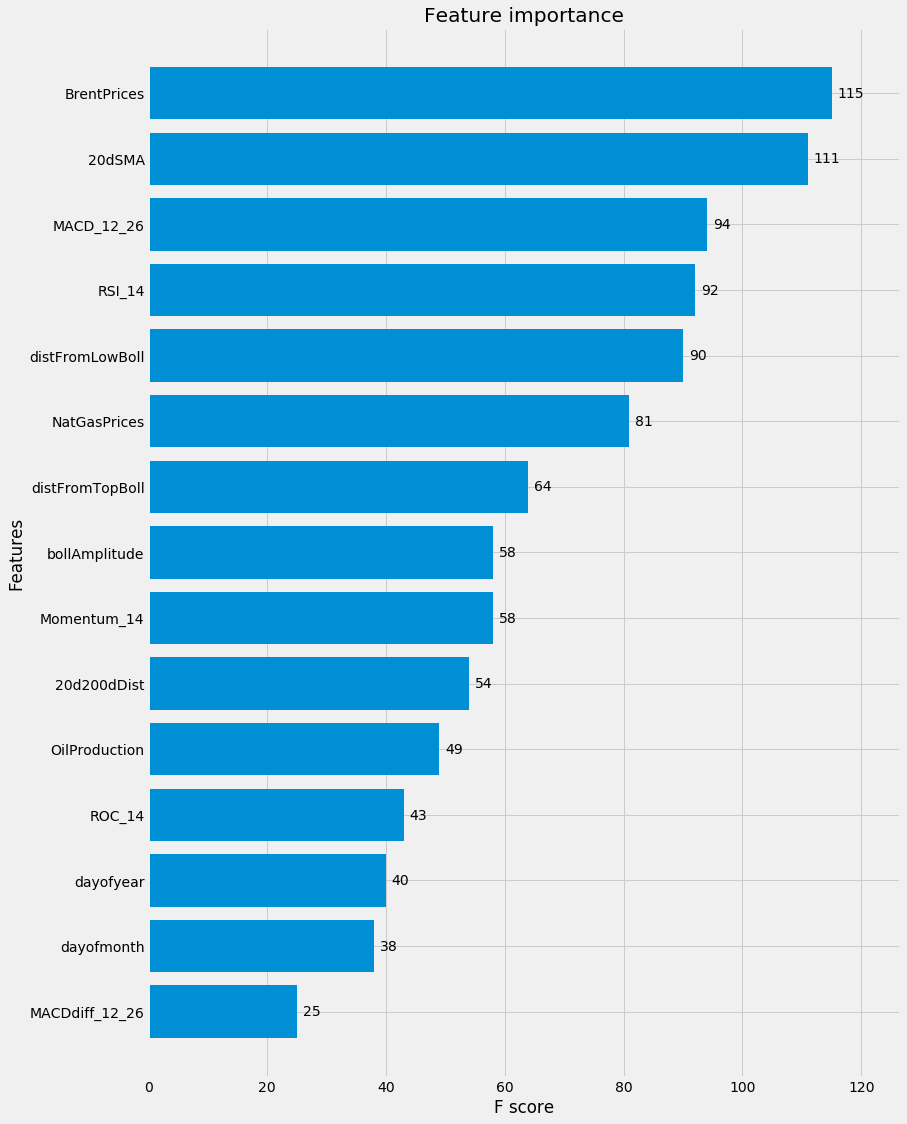

In [237]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

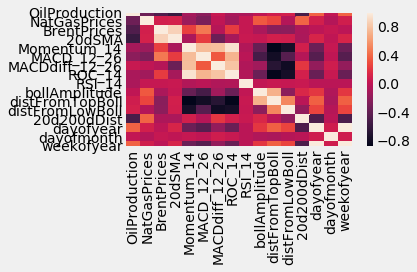

In [238]:
correl = X_train.corr()
sns.heatmap(correl, xticklabels=correl.columns, yticklabels=correl.columns)
plt.tight_layout()
plt.show()

In [239]:
correl

,OilProduction,NatGasPrices,BrentPrices,20dSMA,Momentum_14,MACD_12_26,MACDdiff_12_26,ROC_14,RSI_14,bollAmplitude,distFromTopBoll,distFromLowBoll,20d200dDist,dayofyear,dayofmonth,weekofyear
OilProduction,1.000000,-0.354191,-0.486390,-0.596135,-0.103268,-0.214674,0.042255,-0.089132,-0.079037,0.010295,0.079955,0.099291,-0.516375,0.378404,0.021433,0.383026
NatGasPrices,-0.354191,1.000000,0.093770,0.109940,-0.147685,-0.286350,0.007861,-0.126105,0.038686,0.345508,0.268382,-0.043763,0.386042,0.093137,-0.044394,0.090183
BrentPrices,-0.486390,0.093770,1.000000,0.875315,0.248491,0.469851,-0.034469,0.234994,0.033022,-0.084200,-0.224014,-0.211066,-0.072888,-0.004483,0.033393,-0.006919
20dSMA,-0.596135,0.109940,0.875315,1.000000,-0.082739,0.230890,-0.361359,-0.103836,0.050839,0.035841,0.092034,0.085200,-0.079268,0.125804,0.004696,0.122430
Momentum_14,-0.103268,-0.147685,0.248491,-0.082739,1.000000,0.768315,0.782662,0.953039,-0.047810,-0.383529,-0.875401,-0.758726,0.096161,-0.361358,0.038658,-0.360782
MACD_12_26,-0.214674,-0.286350,0.469851,0.230890,0.768315,1.000000,0.341418,0.730904,-0.011230,-0.529459,-0.784792,-0.455108,-0.037855,-0.456441,0.008330,-0.456044
MACDdiff_12_26,0.042255,0.007861,-0.034469,-0.361359,0.782662,0.341418,1.000000,0.804235,-0.057601,-0.126740,-0.682570,-0.800530,0.214770,-0.181848,0.079852,-0.181092
ROC_14,-0.089132,-0.126105,0.234994,-0.103836,0.953039,0.730904,0.804235,1.000000,-0.052924,-0.356298,-0.860452,-0.770848,0.105494,-0.364728,0.047430,-0.363978
RSI_14,-0.079037,0.038686,0.033022,0.050839,-0.047810,-0.011230,-0.057601,-0.052924,1.000000,0.017455,0.040935,0.036061,0.049436,-0.016685,-0.012722,-0.016959
bollAmplitude,0.010295,0.345508,-0.084200,0.035841,-0.383529,-0.529459,-0.126740,-0.356298,0.017455,1.000000,0.715176,-0.212776,0.136288,0.209791,-0.059934,0.209119


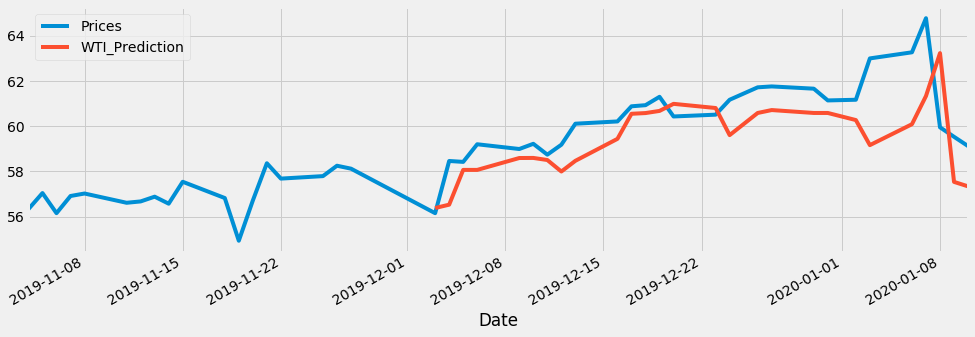

In [240]:
df_test = df_test.iloc[1:]
df_train = df_train.iloc[1:]
df_test['WTI_Prediction'] = model.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)
df_all = df_all.set_index("Date")
_ = df_all[df_all.index > '2019-11-01'][['Prices','WTI_Prediction']].plot(figsize=(15, 5))

In [241]:
X_new = df[df["Date"]>'2020-01-09'].copy()
X_new = create_features(X_new)
X_new


,OilProduction,NatGasPrices,BrentPrices,20dSMA,Momentum_14,MACD_12_26,MACDdiff_12_26,ROC_14,RSI_14,bollAmplitude,distFromTopBoll,distFromLowBoll,20d200dDist,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,,,,,,,
2020-01-10,12900.0,2.207,65.0,61.9935,-2.020001,0.319361,-0.565404,-0.033513,1.679791,5.879897,5.813449,-0.066447,4.06005,10,10,2


In [245]:
new_pred = model.predict(X_new)
new_pred

array([57.83499], dtype=float32)

In [247]:
df["Prices"].iloc[-1]

59.119998931884766

In [246]:
new_pred > df["Prices"].iloc[-1]

array([False])

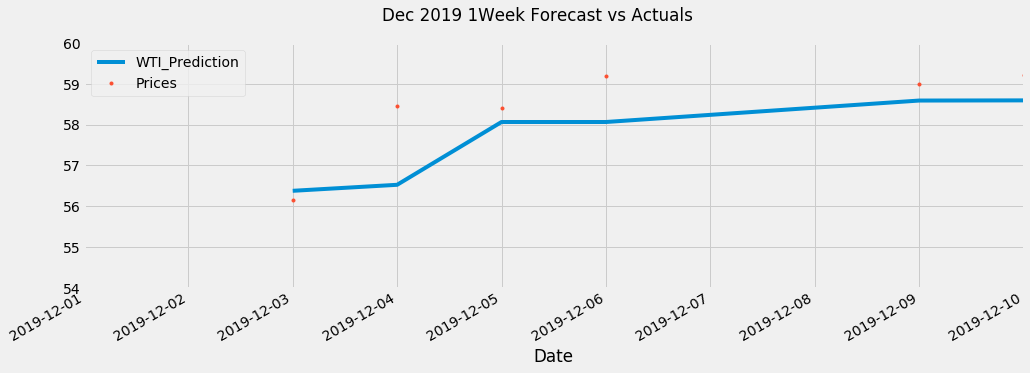

In [227]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['WTI_Prediction','Prices']].plot(ax=ax,style=['-','.'])
ax.set_xbound(lower='2019-12-01', upper='2019-12-10')
ax.set_ylim(54, 60)
plot = plt.suptitle('Dec 2019 1Week Forecast vs Actuals')

In [228]:
mean_squared_error(y_true=df_test['Prices'],
                   y_pred=df_test['WTI_Prediction'])

2.7154743062195337

In [243]:

testSplitDate = '2020-01-03'
fin_df_train = df[df["Date"] <= testSplitDate].copy()
fin_df_test = df[df["Date"] > testSplitDate].copy()

X_train, y_train = create_features(fin_df_train, label='Prices')
X_test, y_test = create_features(fin_df_test, label='Prices')

model = XGBRegressor(
    n_estimators=1000,
    #max_depth=8,
    #min_child_weight=300, 
    #colsample_bytree=0.8, 
    #subsample=0.8, 
    #eta=0.3,    
    #seed=42
    )

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=False, 
    early_stopping_rounds = 100)

[17:25:40] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [230]:
from sklearn.externals import joblib

modDate = str(fin_df_train["Date"].iloc[-1].strftime('%Y-%m-%d'))
filename = 'finalized_model_'+modDate+'.sav'
joblib.dump(model, filename)

['finalized_model_2020-01-03.sav']

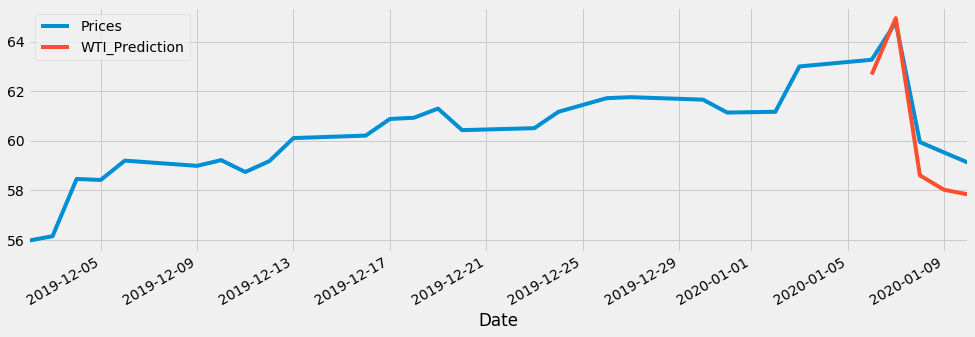

In [244]:
fin_df_test['WTI_Prediction'] = model.predict(X_test)
fin_df_all = pd.concat([fin_df_test, fin_df_train], sort=False)
fin_df_all = fin_df_all.set_index("Date")
_ = fin_df_all[fin_df_all.index > '2019-12-01'][['Prices','WTI_Prediction']].plot(figsize=(15, 5))

In [97]:
fin_df_test

,Date,Prices,OilProduction,NatGasPrices,BrentPrices,20dSMA,10dSMA,5dSMA,50dSMA,200dSMA,...,distFromLowBoll,20d200dDist,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,WTI_Prediction
501,2020-01-06,63.270000,12900.0,2.100,70.250000,60.7295,61.583,62.048000,58.2870,57.82610,...,-5.064386,2.90340,0,1,1,2020,6,6,2,62.714306
502,2020-01-06,63.270000,12900.0,2.100,68.500000,60.9330,61.867,62.370000,58.4344,57.84185,...,-4.994423,3.09115,0,1,1,2020,6,6,2,62.390987
503,2020-01-06,63.270000,12900.0,2.153,70.250000,61.1470,62.143,62.796000,58.5776,57.85830,...,-4.810766,3.28870,0,1,1,2020,6,6,2,62.138393
504,2020-01-06,63.270000,12900.0,2.153,68.500000,61.3495,62.353,63.216000,58.7126,57.88030,...,-4.607235,3.46920,0,1,1,2020,6,6,2,62.009083
505,2020-01-06,62.820000,12900.0,2.100,70.250000,61.5535,62.463,63.180000,58.8570,57.90085,...,-3.729218,3.65265,0,1,1,2020,6,6,2,63.074005
506,2020-01-06,62.820000,12900.0,2.100,68.500000,61.7355,62.569,63.090000,59.0066,57.91560,...,-3.337764,3.81990,0,1,1,2020,6,6,2,62.992153
507,2020-01-06,62.820000,12900.0,2.153,70.250000,61.8710,62.685,63.000000,59.1660,57.93275,...,-3.114926,3.93825,0,1,1,2020,6,6,2,62.652485
508,2020-01-06,62.820000,12900.0,2.153,68.500000,62.0015,62.853,62.910000,59.3420,57.95040,...,-2.874784,4.05110,0,1,1,2020,6,6,2,62.559250
509,2020-01-07,64.779999,12900.0,2.149,70.860001,62.1965,63.214,63.212000,59.5168,57.97335,...,-4.913452,4.22315,1,1,1,2020,7,7,2,64.943077
510,2020-01-08,59.950001,12900.0,2.155,65.739998,62.1475,62.909,62.638000,59.5892,57.96515,...,-0.281081,4.18235,2,1,1,2020,8,8,2,58.598793


,Date,Prices,OilProduction,NatGasPrices,BrentPrices,20dSMA,10dSMA,5dSMA,50dSMA,200dSMA,...,Momentum_14,MACD_12_26,MACDsign_12_26,MACDdiff_12_26,ROC_14,RSI_14,bollAmplitude,distFromTopBoll,distFromLowBoll,20d200dDist
0,2018-01-02,60.370000,9782.0,6.240,66.650000,57.9825,58.923,59.978000,56.6008,50.45180,...,2.530000,1.008636,0.787402,0.221234,0.056898,-0.380868,5.343712,0.284356,-5.059356,7.53070
1,2018-01-03,61.610000,9782.0,6.240,67.850000,58.1890,59.367,60.390000,56.8004,50.51815,...,4.490000,1.143123,0.858546,0.284577,0.088708,-0.212073,6.221374,-0.310313,-6.531687,7.67085
2,2018-01-04,61.980000,9782.0,4.650,68.730000,58.4050,59.816,60.852000,57.0018,50.58910,...,5.390000,1.264980,0.939833,0.325147,0.087368,-0.183997,7.055957,-0.047022,-7.102978,7.81590
3,2018-01-05,61.490000,9492.0,4.650,68.010000,58.6900,60.156,61.182000,57.1852,50.66145,...,4.490000,1.306947,1.013256,0.293691,0.073311,-0.484253,7.118604,0.759302,-6.359302,8.02855
4,2018-01-08,61.730000,9492.0,2.890,68.480000,58.9515,60.495,61.436000,57.3804,50.73365,...,4.440000,1.344079,1.079421,0.264659,0.079762,-0.423550,7.298384,0.870692,-6.427692,8.21785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,2020-01-06,62.820000,12900.0,2.153,68.500000,62.0015,62.853,62.910000,59.3420,57.95040,...,1.650000,1.106829,1.195437,-0.088609,0.017822,-1.128475,4.112569,1.237785,-2.874784,4.05110
509,2020-01-07,64.779999,12900.0,2.149,70.860001,62.1965,63.214,63.212000,59.5168,57.97335,...,3.059999,1.206315,1.197613,0.008703,0.048899,-0.216197,4.659907,-0.253545,-4.913452,4.22315
510,2020-01-08,59.950001,12900.0,2.155,65.739998,62.1475,62.909,62.638000,59.5892,57.96515,...,-1.809999,0.885215,1.135133,-0.249918,-0.027733,1.936502,4.957161,4.676080,-0.281081,4.18235
511,2020-01-09,59.529999,12900.0,2.166,65.309998,62.0590,62.535,61.980000,59.6390,57.95015,...,-2.130001,0.590048,1.026116,-0.436068,-0.026333,1.795266,5.441159,5.249581,-0.191578,4.10885
